In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, WeightedRandomSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [56]:
df = pd.read_excel("/content/drive/MyDrive/Group Project/Dataset/cleaned_data.xlsx")

# Drop irrelevant columns
c = ["what is your race?",
     "what us state or territory do you live in?",
     "what us state or territory do you work in?",
     "why or why not?.1",
     "briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
     "why or why not?",
     "what country do you work in?",
     'what is your gender?',
     'what country do you live in?']

df.drop(c, axis=1, inplace=True)

# Fill employee count with mean
df['how many employees does your company or organization have?'].fillna(df['how many employees does your company or organization have?'].mode()[0], inplace=True)

# Fill age with mean
df['what is your age?'].fillna(df['what is your age?'].mean(), inplace=True)

# Map yes/no to 1 or 0
df['do you currently have a mental health disorder?'].replace(to_replace=['No', 'Yes'], value=[0, 1], inplace=True)

In [57]:
dfX = df.drop(['do you currently have a mental health disorder?'], axis=1)
dfy = df[['do you currently have a mental health disorder?']]

In [58]:
oheX = OneHotEncoder()
X = oheX.fit_transform(dfX).toarray()

ohey = OneHotEncoder()
y = ohey.fit_transform(pd.DataFrame(dfy)).toarray()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=342)

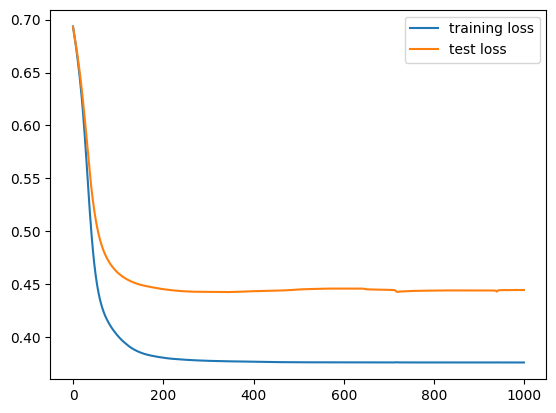

f1-sore:  0.9080234833659491
ROC_AUC score:  0.8880790239057955
Precision score:  0.9027237354085603
Recall score:  0.9133858267716536


In [60]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PCA for dimensionality reduction
principal=PCA(n_components=20)
principal.fit(X_train)
X_trainPCA = principal.transform(X_train)
X_testPCA = principal.transform(X_test)
"""
# Normalization
scaler = StandardScaler()
scaler.fit(X_trainPCA)
X_trainPCA = scaler.transform(X_trainPCA)
X_testPCA = scaler.transform(X_testPCA)
"""
# Converting datasets into pytorch compatible data type
X_train = torch.FloatTensor(X_trainPCA)
X_test = torch.FloatTensor(X_testPCA)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Casting dataset into pytorch dataloader
train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=128)
test = TensorDataset(X_test, y_test)
test_loader = DataLoader(test, batch_size=128)

# Neural network architecture
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=20, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=8)
        self.output = nn.Linear(in_features=8, out_features=2)
        self.output2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        x = self.output2(x)
        return x

model = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training
epochs = 1000
lossarr = []
num_batches = len(test_loader)
testloss = []
for i in range(epochs):
    model.train()
    for batch, (x, y) in enumerate(train_loader):
        y_hat = model.forward(x)
        loss = criterion(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossarr.append(loss.item())

    model.eval()
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            preds.extend(pred)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    testloss.append(test_loss/num_batches)

plt.plot(list(range(epochs)), lossarr, label="training loss")
plt.plot(list(range(epochs)), testloss, label="test loss")
plt.legend()
plt.show()

model.eval()
proba = []
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        proba.extend([p[1] for p in pred])

y_true = [i[1] for i in y_test]
preds = [1 if i > 0.5 else 0 for i in proba]

print("f1-sore: ", f1_score(y_true, preds))
print("ROC_AUC score: ", roc_auc_score(y_true, proba))
print("Precision score: ", precision_score(y_true, preds))
print("Recall score: ", recall_score(y_true, preds))